In [1]:
# install libraries
!pip install hazm
!pip install transformers
# !pip install pandas
# !pip install gensim
# !pip install matplotlib
# !pip install seaborn
# !pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 15.6 MB/s 
     |████████████████████████████████| 1.4 MB 40.0 MB/s 
     |████████████████████████████████| 233 kB 19.9 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394489 sha256=5df61f64e401480ae8001bb03af12201f34631c744f2411fd7786046731947bd
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154101 sha256=e5c29c5e8c27c695459dcd35fec833d14ad56d24f68bce7a345fc8d97b28233c
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https:/

In [18]:
# libraries
import codecs
import os
import json
import torch
import tqdm
import random
import pickle
from collections import Counter
from nltk import FreqDist
import pandas as pd
import numpy as np
import itertools
from hazm import *
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from transformers import AutoModelForSequenceClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [1]:
#!unzip new-dataset-with-category.zip

In [3]:
import json

#colab
#DIRNAME = 'new-dataset-with-category'
#local
DIRNAME = '../new-dataset-with-category'
data = []
for i in range(1, 31):
    with open(f'{DIRNAME}/namnak-{i}.json', 'r', encoding="utf-8") as f:
        data.extend(json.loads(f.read()))

In [4]:
len(data)

7053

# Fasttext Embedding

In [5]:
class FastTextEmbedingModel:
    def __init__(self):
        self.ft_model = FastText.load('../models/_fasttext.model')
        self.normalizer = Normalizer()
        stopwords = [self.normalizer.normalize(x.strip()) for x in
                     codecs.open('../stopwords/stopwords.txt', 'r', 'utf-8').readlines()]
        custom_stop_words = [self.normalizer.normalize(x.strip()) for x in
                             codecs.open('../stopwords/custom_stopwords.txt', 'r', 'utf-8').readlines()]
        self.total_stop_words = custom_stop_words + stopwords
        
    def get_doc_embeding(self, doc):
        doc_title, doc_text = self.get_text_and_title(doc)
        return self.__get_doc_embeding(doc_title, doc_text)

    def __get_doc_embeding(self, doc_title, doc_text):
        return ((self.get_text_embeding(doc_text) * 19) + self.get_text_embeding(doc_title)) / 20
    
    def get_text_embeding(self, text):
        tokens = [_ for _ in word_tokenize(self.normalizer.normalize(text)) if _ not in self.total_stop_words]
        emb = np.zeros(self.ft_model.wv.vector_size)
        for token in tokens:
            emb += self.ft_model.wv[token]
        emb /= len(tokens)
        return emb
    
    def get_text_and_title(self, doc):
        return doc['title'], doc['abstract'] + " " + " ".join(doc['paragraphs'])

In [6]:
fasttext_embeding_model = FastTextEmbedingModel()

# Prepare Documents Embedding

In [7]:
category_dictionary = {
    'سلامت روان' : 0,
    'دهان و دندان' : 1,
    'پوست و مو' : 2,
    'تغذیه' : 3,
    'سلامت خانواده' : 4,
    'سلامت جنسی' : 5,
    'پیشگیری و بیماریها' : 6
}

In [8]:
doc_num = {_:0 for _ in category_dictionary.values()}
doc_num_threshold = 350

X = list()
X_text = list()
y = list()
shuffeled_data = random.sample(data ,len(data))
doc_titles = list()

for i in tqdm.tqdm(range(0, len(shuffeled_data))):
    doc = shuffeled_data[i]
    if doc['category'] in category_dictionary.keys() and doc_num[category_dictionary[doc['category']]] < doc_num_threshold:
        doc_num[category_dictionary[doc['category']]] += 1
        y.append(category_dictionary[doc['category']])
        X.append(fasttext_embeding_model.get_doc_embeding(doc))
        X_text.append(doc['abstract'] + " " + " ".join(doc['paragraphs']))
        doc_titles.append(doc['title'])

100%|█████████████████████████████████████████████████████████████████████████████| 7053/7053 [00:27<00:00, 258.39it/s]


In [9]:
Counter(y)

Counter({6: 350, 4: 339, 3: 350, 2: 350, 0: 350, 1: 345, 5: 350})

# train test split data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [11]:
len(X_test)

366

In [12]:
len(X_train)

2068

# confusion matrix drawer

In [13]:
def draw_confusion_matrix(y_test, y_predicted):
    conf_matrix = confusion_matrix(y_test, y_predicted)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

# model testers

In [14]:
def test_model(y_test, y_predicted):
    print(f"F1-Macro: {f1_score(y_test, y_predicted, average='macro')}")
    print(f"Accuracy: {accuracy_score(y_test, y_predicted)}")
    print(f"--------------------------------")
    draw_confusion_matrix(y_test, y_predicted)

# Naive Bayes Classification

F1-Macro: 0.7218797480868127
Accuracy: 0.726775956284153
--------------------------------


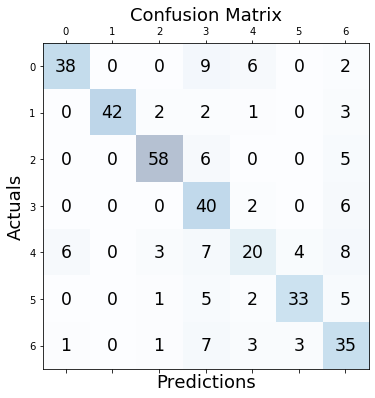

In [21]:
gnb_clf = GaussianNB().fit(X_train, y_train)
y_predicted_gnb = gnb_clf.predict(X_test)
test_model(y_test, y_predicted_gnb)

In [22]:
pickle.dump(gnb_clf, open('../models/classification-clustering/naive-bayes.sav', 'wb'))

# Logistic Regression Classification

In [15]:
lr_clf = LogisticRegression(random_state=20).fit(X_train, y_train)

C:\Users\Mahdi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


F1-Macro: 0.8180433504525697
Accuracy: 0.8224043715846995
--------------------------------


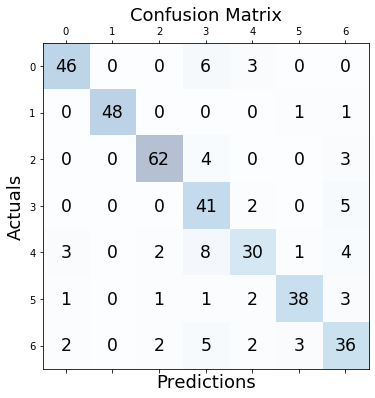

In [16]:
y_predicted_lr = lr_clf.predict(X_test)
test_model(y_test, y_predicted_lr)

In [19]:
pickle.dump(lr_clf, open('../models/classification-clustering/logistic-regression.sav', 'wb'))

In [23]:
lr_clf = pickle.load(open('../models/classification-clustering/logistic-regression.sav', 'rb'))

# Transformer based model

In [3]:
from transformers import BigBirdModel, AutoTokenizer

MODEL_NAME = "SajjadAyoubi/distil-bigbird-fa-zwnj"
model = BigBirdModel.from_pretrained(MODEL_NAME, block_size=32)
model = BigBirdModel.from_pretrained(MODEL_NAME, attention_type="original_full")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/837 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300M [00:00<?, ?B/s]

Some weights of the model checkpoint at SajjadAyoubi/distil-bigbird-fa-zwnj were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdModel were not initialized from the model checkpoint at SajjadAyoubi/distil-bigbird-fa-zwnj and are newly initialized: ['bert.pooler.

Downloading:   0%|          | 0.00/365 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
model = BigBirdModel.from_pretrained('../models/pretrained-transformer-model.model')
tokenizer = AutoTokenizer.from_pretrained('../models/pretrained-transformer-tokenizer')

In [10]:
X_train, X_testval, y_train, y_testval = train_test_split(X_text, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=1)

In [11]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)
# test_encodings = tokenizer([' '.join(x) for x in X_test], truncation=True, padding=True)

In [12]:
class HealthDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HealthDataset(train_encodings, y_train)
val_dataset = HealthDataset(val_encodings, y_val)
test_dataset = HealthDataset(test_encodings, y_test)

In [61]:
cl_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7).to("cuda")

loading configuration file https://huggingface.co/SajjadAyoubi/distil-bigbird-fa-zwnj/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/65c4890aad691558d5d5b16b790cbee0c2946d954245a591a90863f07cd3781f.8b5640f62e67e0df28c071fd855141c657ac9dc35a647faa42495fe0a93f41e1
Model config BigBirdConfig {
  "_name_or_path": "SajjadAyoubi/distil-bigbird-fa-zwnj",
  "architectures": [
    "BigBirdForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "block_sparse",
  "block_size": 32,
  "bos_token_id": null,
  "classifier_dropout": null,
  "eos_token_id": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_

In [64]:
import gc
torch.cuda.empty_cache()
gc.collect()

3119

In [65]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,            # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)


trainer = Trainer(
    model=cl_model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1947
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4870
/usr/local/lib/python3.7/dist-packages/transformers/models/big_bird/modeling_big_bird.py:983: UserWarning: __floordiv__ is deprecated, and its beh

Step,Training Loss
10,1.957200
20,1.922400
30,1.897600
40,1.912800
50,1.928900
60,1.837600
70,1.862300
80,1.768300
90,1.803000
100,1.691500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/models/big_bird/modeling_big_bird.py:983: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/models/big_bird/modeling_big_bird.py:983: UserWarning: __floordiv__ is deprecated, and its

TrainOutput(global_step=4870, training_loss=0.2412943029017723, metrics={'train_runtime': 1803.2423, 'train_samples_per_second': 10.797, 'train_steps_per_second': 2.701, 'total_flos': 2614694622566400.0, 'train_loss': 0.2412943029017723, 'epoch': 10.0})

In [66]:
y_pred_transformers = []
for x in tqdm.tqdm(X_test):
    _input = tokenizer(x, truncation=True, padding=True, return_tensors='pt').to("cuda")
    output = cl_model(**_input)
    y_pred_transformers.append(output[0].softmax(1).argmax().item())

  0%|          | 0/244 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/models/big_bird/modeling_big_bird.py:983: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from
  1%|          | 3/244 [00:00<00:23, 10.27it/s]Input ids are automatically padded from 511 to 512 to be a multiple of `config.block_size`: 32
Attention type 'block_sparse' is not possible if sequence_length: 324 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 352 with config.block_size = 32, config.nu

F1-Macro: 0.8311190353650467
Accuracy: 0.8360655737704918
--------------------------------


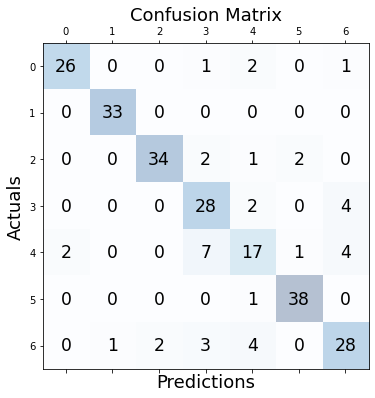

In [69]:
test_model(y_test, y_pred_transformers)

In [70]:
cl_model.save_pretrained('transformer_model')

Configuration saved in transformer_model/config.json
Model weights saved in transformer_model/pytorch_model.bin


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('../models/transformer_model', local_files_only=True).to('cuda')

In [71]:
!zip -r /content/sample_data.zip /content/transformer_model

  adding: content/transformer_model/ (stored 0%)
  adding: content/transformer_model/config.json (deflated 56%)
  adding: content/transformer_model/pytorch_model.bin (deflated 7%)


In [74]:
from google.colab import files
files.download('/content/sample_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>